In [2]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

trainRoad = "./MNIST_dataset/train.csv"

In [22]:
print(torchvision.__version__)

0.11.3


In [3]:
# dataset class

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

In [4]:
mnist_dataset = MnistDataset("D:/火狐下载/mnist_train.csv")

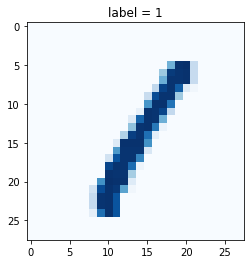

In [8]:
mnist_dataset.plot_image(3)

In [5]:
#构建鉴别器
class Discriminator(nn.Module):
    
    def __init__(self):
        # 初始化pytorch父类
        super().__init__()
        
        #定义神经网络
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyRelu(),
            
            nn.LayerNorm(200),
            
            nn.Linear(200, 1),
            nn.LeakyRelu(),
            
        )
        #创建损失函数//二院交叉熵BCELoss替换均方误差MSELoss
        self.loss_function = nn.BCELoss()
        
        #创建优化器,使用随机梯度下降
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.01)
        
        #计时器和进程记录
        self.counter = 0
        self.progress = []
        
        pass
    
    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        #计算网络的输出
        outputs = self.forward(inputs)

        #计算损失值
        loss = self.loss_function(outputs, targets)

        #每训练10次增加计数器
        self.counter += 1;
        if(self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if(self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        #归零梯度， 反向传播 ，并更新新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid = True, yticks=(0, 0.25, 0.5))
        pass

pass

In [7]:
# function to generate uniform random data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data
     

In [8]:
# test discriminator can separate real data from random noise

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


In [13]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random(784) ).item() )
  pass

0.9933686852455139
0.9967097043991089
0.9959673881530762
0.9969314336776733
0.006678259000182152
0.004728205502033234
0.006089822389185429
0.005525047890841961


In [14]:
class Generator(nn.Module):
    
    def __init__(self):
  # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 200),
            nn.LeakyRule(),
            
            nn.LayerNorm(200),
            nn.Linear(200, 784),
            nn.LeakyRule()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):
        
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        #计算网络输出
        g_output = self.forward(inputs)
        
        #输入鉴别器
        d_output = D.forward(g_output)
        
        #计算损失函数
        loss = D.loss_function(d_output, targets)
        
            #每训练10次增加计数器
        self.counter += 1;
        if(self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 0.25, 0.5), figsize=(16,8), alpha=0.1, marker='.', grid = True, yticks=(0, 0.25, 0.5))
        pass



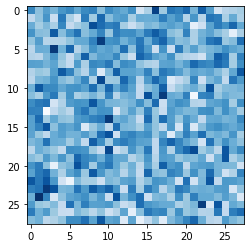

In [15]:
# check the generator output is of the right type and shape

G = Generator()

output = G.forward(generate_random(1))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [16]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

# train Discriminator and Generator

for label, image_data_tensor, target_tensor in mnist_dataset:

    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random(1), torch.FloatTensor([1.0]))

    pass
     

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


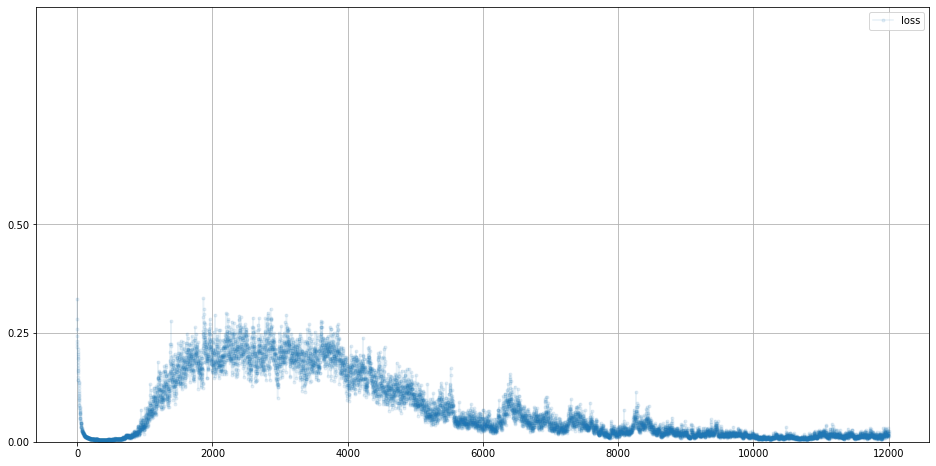

In [17]:
D.plot_progress()


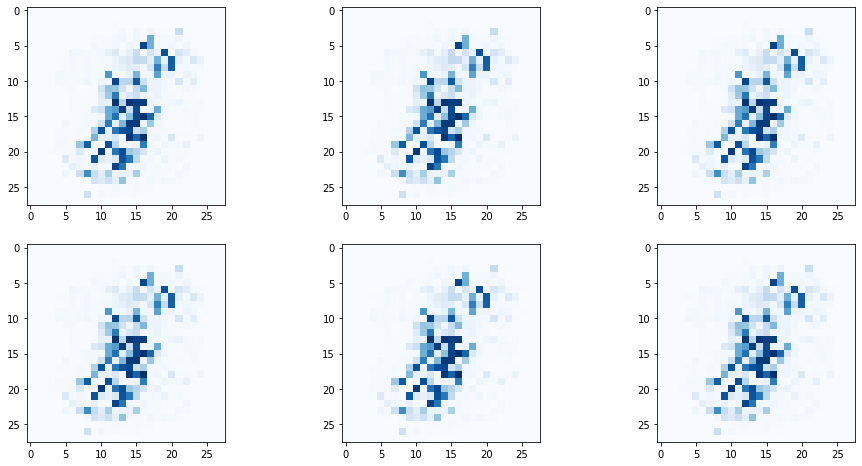

In [18]:

# plot several outputs from the trained generator

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random(1))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass